# Image Data Processing and Augmentation(to make more data)

## Setup and Data Path Configuration

In [128]:
import os
from google.colab import drive
drive.mount('/content/drive')

#shared path to drive
SHARED_PATH="/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"
#direct path to drive
DIRECT_PATH="/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"

# Determine the data path based on the existence of shared or direct paths
root_path = SHARED_PATH if os.path.exists(SHARED_PATH) else DIRECT_PATH if os.path.exists(DIRECT_PATH) else None

DATA_PATH = ''
# Print the chosen path or an error message
if root_path:
    DATA_PATH = root_path + "/Proj2_Heritage_places_in_CGR_classify"
    print(f"Using path: {root_path}\n\n{os.listdir(DATA_PATH)}")
else:
    print("Neither shared nor direct path exists. Please check the paths.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using path: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours

['Data', 'data.csv', 'old_experiments', 'ResNet18_with_20_accy.pth', 'expr2_effnet.ipynb', 'expr1_resnet18.ipynb', 'Copy of RUN_THIS_all_in_one_changable_expr.ipynb', 'make_csv_data.ipynb']


## Functions Definitions ...

### Image augmentation & edits

In [129]:
import os
import random
import numpy as np
import albumentations as A
import cv2

def augment_image(image_path, output_folder, n_aug_per_image):
    """
    Loads an image using OpenCV, applies augmentations with Albumentations,
    and saves the augmented versions.
    Args:
        image_path (str): Full path to the input image.
        output_folder (str): Path to the folder where augmented images will be saved.
        num_augmentations_per_image (int): Number of augmented versions to create for each image.
    """
    try:
        # Load image using OpenCV (loads in BGR format by default)
        img_np = cv2.imread(image_path)
        # Albumentations expects RGB, so convert from BGR
        img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)

        img_name = os.path.basename(image_path)
        base_name, extension = os.path.splitext(img_name)

        # Define an augmentation pipeline using Albumentations
        edit_img = A.Compose([
            A.RandomBrightnessContrast(p=0.7),
            A.HueSaturationValue(p=0.4),
            A.HorizontalFlip(p=0.5),
            A.RandomResizedCrop(
                size=(img_np.shape[0], img_np.shape[1]),
                scale=(0.85, 1.0), ratio=(0.75, 1.33), p=0.4
            ),
            A.Affine(
                shear={"y": (-0, 0), "x": (-10, 10)}, p=0.2,
                border_mode=cv2.BORDER_REFLECT # for not to create black border
            ),
            A.Rotate(
                limit=10, p=0.4, border_mode=cv2.BORDER_REFLECT
            ),
        ])

        for i in range(n_aug_per_image):
            # Apply the augmentation pipeline
            augmented_img_dict = edit_img(image=img_np) # {'image':array([]), 'dtype':int64}
            augmented_img_np = augmented_img_dict['image']

            # Convert back to BGR for saving with cv2.imwrite
            augmented_img_np_bgr = cv2.cvtColor(augmented_img_np, cv2.COLOR_RGB2BGR)

            # Save the augmented image using OpenCV
            augmented_img_name = f"{base_name}_aug{i}{extension}"
            augmented_img_path = os.path.join(output_folder, augmented_img_name)
            cv2.imwrite(augmented_img_path, augmented_img_np_bgr)
        print(f"  Generated..{n_aug_per_image} ")

    except Exception as e:
        print(f"Error processing {image_path}: {e}")

### to make more Samples

In [130]:
def process_folder_perform_augment(data_folder,n_duplicate=1):
    """
    Iterates through all images in the specified folder and applies augmentation.
    """
    if not os.path.exists(data_folder):
        print(f"Error: Folder '{data_folder}' not found.")
        return

    print(f"Starting augmentation for images in: {data_folder}")
    for root, _, files in os.walk(data_folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                image_path = os.path.join(root, file)
                print(f"Processing: {file}", end="")
                augment_image(image_path, root, n_duplicate) # Saving in the same folder

### Delete images with suffix given

In [131]:
import re # Import the regular expression module

def delete_files_with_regix_suffix(folder_path, suffix_pattern):
    """
    Deletes files in a folder that match a given suffix pattern using regex.
    """
    print(f"Searching for and removing files matching pattern '{suffix_pattern}'\n-in: {folder_path}")
    for root, _, files in os.walk(folder_path):
        for file in files:
            # Use re.search to find the pattern in the filename (case-insensitive)
            if re.search(suffix_pattern, file, re.IGNORECASE):
                file_path = os.path.join(root, file)
                os.remove(file_path)
        # print(f"Removed duplicate of: {files}")


### Dataframe Creation and Exploration

In [132]:
import pandas as pd

def create_image_dataframe(root_dir):
    image_dict = {}
    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)
        if os.path.isdir(folder_path):
            image_dict[folder] = []
            for filename in os.listdir(folder_path):
                # You can add an extension check here if needed
                # if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                rel_path = folder_path.split('/')
                image_path = os.path.join('/', rel_path[-2], rel_path[-1], filename)
                image_dict[folder].append(image_path)

    data = []
    for class_name, images in image_dict.items():
        for img_path in images:
            data.append({'path': img_path, 'class': class_name})

    df = pd.DataFrame(data)
    return df



### list subfolder items


In [133]:
def count_items_in_subfolders(folder_path):
    if not os.path.isdir(folder_path):
        print(f"Error: '{folder_path}' is not a valid directory.")
        return

    # Iterate through each subfolder and count the items
    for subfolder_name in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder_name)
        if os.path.isdir(subfolder_path): # Check if it's actually a directory
            item_count = len(os.listdir(subfolder_path))
            print(f"{subfolder_name:<15}-- ({item_count} items)")

## Image dataset maximizing

In [134]:
folder_path = DATA_PATH + '/Data'
# Define the pattern: '_aug' followed by one or more digits, then a dot and any extension
suffix_pattern = r'_aug\d+\..+'

In [135]:
delete_files_with_regix_suffix(folder_path, suffix_pattern)
count_items_in_subfolders(folder_path)
dupl_frequency = { # for making approx 100 sample each
    'mondir' : 10,
    'jora_ghat': 5,
    'charch': 6,
    'patalbari': 10,
    'musium': 5,
    'clock_tower': 12,
}
# for making 200 sample
# dupl_frequency = {
#     'mondir' : 21,
#     'jora_ghat': 11,
#     'charch': 13,
#     'patalbari': 21,
#     'musium': 12,
#     'clock_tower': 24,
# }

Searching for and removing files matching pattern '_aug\d+\..+'
-in: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/Proj2_Heritage_places_in_CGR_classify/Data
mondir         -- (9 items)
jora_ghat      -- (17 items)
charch         -- (14 items)
patalbari      -- (9 items)
musium         -- (16 items)
clock_tower    -- (8 items)


In [136]:
process_folder_perform_augment(folder_path+'/mondir', dupl_frequency['mondir'])
count_items_in_subfolders(folder_path)

Starting augmentation for images in: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/Proj2_Heritage_places_in_CGR_classify/Data/mondir
Processing: tmpl_0007.JPG  Generated..10 
Processing: tmpl_0008.jpg  Generated..10 
Processing: tmpl_0006.jpg  Generated..10 
Processing: tmpl_0004.jpeg  Generated..10 
Processing: tmpl_0003.jpg  Generated..10 
Processing: tmpl_0001.jpg  Generated..10 
Processing: tmpl_0009.jpeg  Generated..10 
mondir         -- (79 items)
jora_ghat      -- (17 items)
charch         -- (14 items)
patalbari      -- (9 items)
musium         -- (16 items)
clock_tower    -- (8 items)


In [137]:
process_folder_perform_augment(folder_path+'/jora_ghat', dupl_frequency['jora_ghat'])
count_items_in_subfolders(folder_path)

Starting augmentation for images in: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/Proj2_Heritage_places_in_CGR_classify/Data/jora_ghat
Processing: ghat_00016.jpg  Generated..5 
Processing: ghat_00015.jpg  Generated..5 
Processing: ghat_00014.JPG  Generated..5 
Processing: ghat_00011.jpg  Generated..5 
Processing: ghat_0009.jpg  Generated..5 
Processing: ghat_0008.jpg  Generated..5 
Processing: ghat_0007.jpg  Generated..5 
Processing: ghat_0006.jpg  Generated..5 
Processing: ghat_0004.jpeg  Generated..5 
Processing: ghat_0003.jpg  Generated..5 
Processing: ghat_0002.jpg  Generated..5 
Processing: ghat_0001.jpg  Generated..5 
Processing: ghat_00017.jpeg  Generated..5 
Processing: ghat_00013.jpeg  Generated..5 
mondir         -- (79 items)
jora_ghat      -- (87 items)
charch         -- (14 items)
patalbari      -- (9 items)
musium         -- (16 items)
clock_tower    -- (8 items)


In [138]:
process_folder_perform_augment(folder_path+'/charch', dupl_frequency['charch'])
count_items_in_subfolders(folder_path)

Starting augmentation for images in: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/Proj2_Heritage_places_in_CGR_classify/Data/charch
Processing: crch_00014.JPG  Generated..6 
Processing: crch_00013.jpg  Generated..6 
Processing: crch_00012.jpg  Generated..6 
Processing: crch_00011.jpg  Generated..6 
Processing: crch_00010.png  Generated..6 
Processing: crch_0009.jpg  Generated..6 
Processing: crch_0008.jpg  Generated..6 
Processing: crch_0006.jpg  Generated..6 
Processing: crch_0005.jpg  Generated..6 
Processing: crch_0004.jpg  Generated..6 
Processing: crch_0003.jpg  Generated..6 
Processing: crch_0002.jpg  Generated..6 
mondir         -- (79 items)
jora_ghat      -- (87 items)
charch         -- (86 items)
patalbari      -- (9 items)
musium         -- (16 items)
clock_tower    -- (8 items)


In [139]:
process_folder_perform_augment(folder_path+'/patalbari', dupl_frequency['patalbari'])
count_items_in_subfolders(folder_path)

Starting augmentation for images in: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/Proj2_Heritage_places_in_CGR_classify/Data/patalbari
Processing: pb_0004.JPG  Generated..10 
Processing: pb_0002.jpeg  Generated..10 
Processing: pb_0001.jpg  Generated..10 
Processing: pb_0005.jpeg  Generated..10 
Processing: pb_0006.jpeg  Generated..10 
Processing: pb_0007.jpeg  Generated..10 
Processing: pb_0008.jpeg  Generated..10 
Processing: pb_0009.jpeg  Generated..10 
mondir         -- (79 items)
jora_ghat      -- (87 items)
charch         -- (86 items)
patalbari      -- (89 items)
musium         -- (16 items)
clock_tower    -- (8 items)


In [140]:
process_folder_perform_augment(folder_path+'/musium', dupl_frequency['musium'])
count_items_in_subfolders(folder_path)

Starting augmentation for images in: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/Proj2_Heritage_places_in_CGR_classify/Data/musium
Processing: mus_00015.JPG  Generated..5 
Processing: mus_00014.jpg  Generated..5 
Processing: mus_00013.jpg  Generated..5 
Processing: mus_00012.jpg  Generated..5 
Processing: mus_00011.jpg  Generated..5 
Processing: mus_00010.png  Generated..5 
Processing: mus_0008.jpg  Generated..5 
Processing: mus_0007.jpg  Generated..5 
Processing: mus_0006.jpg  Generated..5 
Processing: mus_0004.jpg  Generated..5 
Processing: mus_0003.jpg  Generated..5 
Processing: mus_0002.jpeg  Generated..5 
Processing: mus_0001.jpg  Generated..5 
Processing: mus_0010.jpeg  Generated..5 
mondir         -- (79 items)
jora_ghat      -- (87 items)
charch         -- (86 items)
patalbari      -- (89 items)
musium         -- (86 items)
clock_tower    -- (8 items)


In [141]:
process_folder_perform_augment(folder_path+'/clock_tower', dupl_frequency['clock_tower'])
count_items_in_subfolders(folder_path)

Starting augmentation for images in: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/Proj2_Heritage_places_in_CGR_classify/Data/clock_tower
Processing: ct_0006.jpg  Generated..12 
Processing: ct_0005.jpg  Generated..12 
Processing: ct_0003.jpg  Generated..12 
Processing: ct_0001.jpg  Generated..12 
Processing: ct_0007.jpeg  Generated..12 
Processing: ct_0008.jpeg  Generated..12 
mondir         -- (79 items)
jora_ghat      -- (87 items)
charch         -- (86 items)
patalbari      -- (89 items)
musium         -- (86 items)
clock_tower    -- (80 items)


## Saving Dataframe and Visualizing Class Distribution

In [142]:
# Example usage:
# DATA_PATH is assumed to be defined from the previous cells
df = create_image_dataframe(DATA_PATH + '/Data')
print(df)
print(df.describe())
# save csv data
df.to_csv(DATA_PATH+'/data.csv', index=False)
os.listdir(DATA_PATH)

                                     path        class
0              /Data/mondir/tmpl_0007.JPG       mondir
1              /Data/mondir/tmpl_0008.jpg       mondir
2              /Data/mondir/tmpl_0006.jpg       mondir
3             /Data/mondir/tmpl_0005.webp       mondir
4             /Data/mondir/tmpl_0004.jpeg       mondir
..                                    ...          ...
502   /Data/clock_tower/ct_0008_aug7.jpeg  clock_tower
503   /Data/clock_tower/ct_0008_aug8.jpeg  clock_tower
504   /Data/clock_tower/ct_0008_aug9.jpeg  clock_tower
505  /Data/clock_tower/ct_0008_aug10.jpeg  clock_tower
506  /Data/clock_tower/ct_0008_aug11.jpeg  clock_tower

[507 rows x 2 columns]
                                        path      class
count                                    507        507
unique                                   507          6
top     /Data/clock_tower/ct_0008_aug11.jpeg  patalbari
freq                                       1         89


['Data',
 'data.csv',
 'old_experiments',
 'ResNet18_with_20_accy.pth',
 'expr2_effnet.ipynb',
 'expr1_resnet18.ipynb',
 'Copy of RUN_THIS_all_in_one_changable_expr.ipynb',
 'make_csv_data.ipynb']

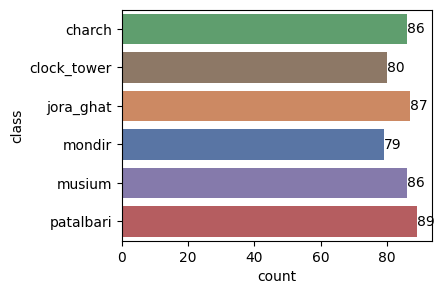

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
ax = sns.countplot(y='class', data=df, hue='class', palette='deep',order=sorted(df['class'].unique()))

# Add bar counts
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.show()